In [7]:
%cd /home/users/rx31/Projects/survival_data/analysis

/usr/project/xtmp/rx31/Projects/survival_data/analysis


In [8]:
import matplotlib.pyplot as plt
import pandas as pd 
from sksurv.nonparametric import kaplan_meier_estimator

In [9]:
df_source = pd.read_csv('../churn-fold_0-depth_3-reg_0.1.csv')

In [10]:
df_source['p'].unique()


array([7., 4., 0., 2., 5., 1., 3., 6.])

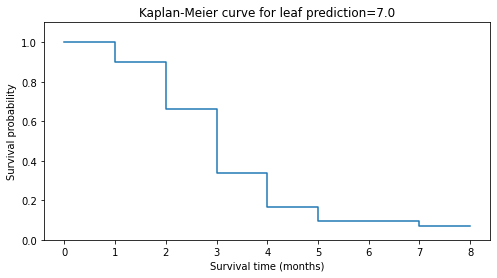

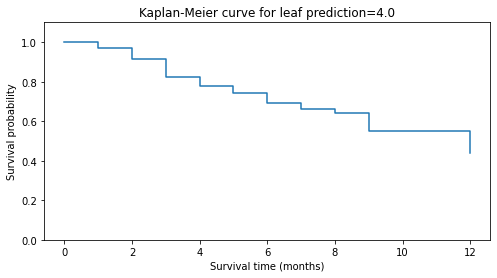

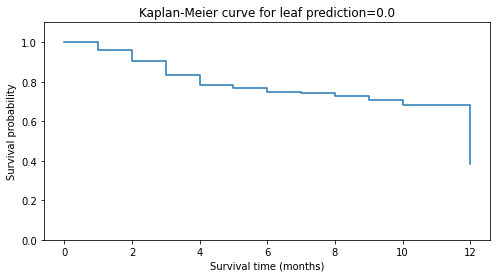

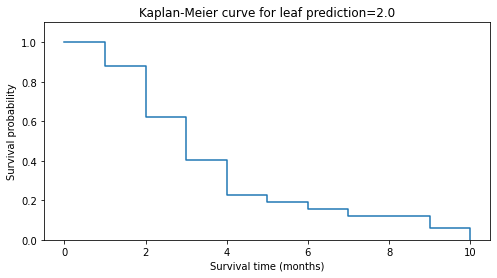

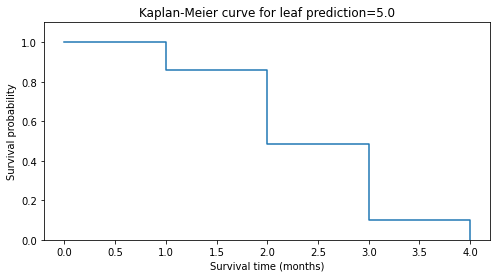

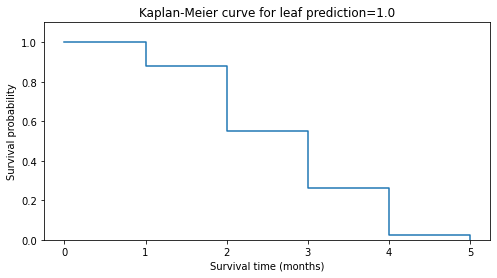

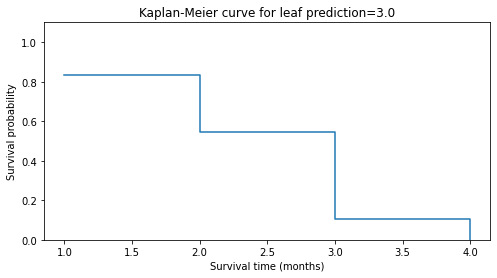

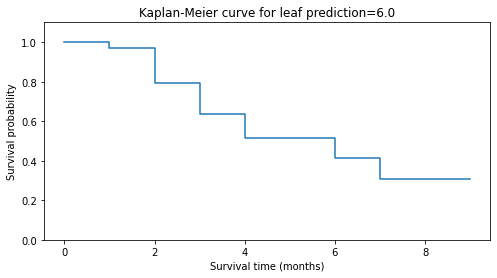

In [12]:
for leaf in df_source['p'].unique():
    df = df_source[df_source['p'] == leaf]
    duration, survival_probability = kaplan_meier_estimator(df['c']==1, df['y'])
    plt.figure(figsize=(4,4))
    plt.step(x=duration, y=survival_probability, where="post")
    plt.ylim(0,1.1)
    plt.xlabel("Survival time (months)")
    plt.ylabel("Survival probability")
    plt.title(f"Kaplan-Meier curve for leaf prediction={leaf}");

In [1]:

def ort_train(X, died, times, lamb, num_threads, max_depth):
    """
    Train dataset with IAI ORT model, dataset is assumed preprocessed without missing values

    :param X: binary feature, nd array
    :param died: censoring, 1d vector
    :param times: death time. 1d vector
    :param lamb: penalty on num_leaves, float
    :param num_threads: number of IAI parallel workers, integer
    :param normalize_y: bool
    :param max_depth: max depth allowed, integer
    :return: fitted ORT model
    """

    ost = iai.OptimalTreeSurvivalLearner(
        random_seed=1,
        num_threads=num_threads,
        show_progress=False,
        max_depth=max_depth,
        cp=lamb
    )


    ost.fit(X, died, times)


    return ost

In [ ]:

parser = argparse.ArgumentParser()
dataset_name = 'real_estate'
fold_number = 1
no_depth = False
parser.add_argument('dataset_name', nargs='?', default=dataset_name)
parser.add_argument('fold_number', nargs='?', default=fold_number)
args = parser.parse_args()

# parse argument
dataset_name = args.dataset_name
fold_number = int(args.fold_number)


# parse argument
dataset_path = Path(data_mapping[dataset_name]['dataset_path'])

assert(dataset_path.exists())

# TODO: put this logic in its function
if fold_number == 0:
    train_dataset_path = str(dataset_path)
    test_dataset_path = None
    result_path = dataset_path.parent / 'iai_results' / f'{dataset_path.stem}.json'
else:
    train_dataset_path = f"{dataset_path.parent / dataset_path.stem}_train_fold_{fold_number}{dataset_path.suffix}"
    test_dataset_path = f"{dataset_path.parent / dataset_path.stem}_test_fold_{fold_number}{dataset_path.suffix}"
    result_path = dataset_path.parent / 'iai_results' / f'{dataset_path.stem}_fold_{fold_number}.json'


result_path.parent.mkdir(exist_ok=True)




print("Start IAI test.     Dataset: ", dataset_name, ' fold: ', str(fold_number))
data = pd.read_csv(train_dataset_path)
X = data.iloc[:, :-2].to_numpy()
died = data.iloc[:, -2].to_numpy() == 1
times = data.iloc[:, -1].to_numpy()
numSamples, numFeatures = X.shape
# sort samples by time
sort_order = np.argsort(times)
X = X[sort_order]
died = died[sort_order]
times = times + 0.0000000001
times = times[sort_order]
# normalize y
times = times / times[-1]
if test_dataset_path:
    test_data = pd.read_csv(test_dataset_path)
    X_test = test_data.iloc[:, :-2].to_numpy()
    died_test = test_data.iloc[:, -2].to_numpy() == 1
    times_test = test_data.iloc[:, -1].to_numpy()
    # sort test samples
    sort_order = np.argsort(times_test)
    X_test = X_test[sort_order]
    died_test = died_test[sort_order]
    times_test = times_test + 0.0000000001
    times_test = times_test[sort_order]
    # normalize y_test
    times_test = times_test / times_test[-1]


if result_path.exists() and not OVERRIDE:
    with open(result_path) as f:
        results = json.load(f)
    execution_results = results['execution_results']
else:
    results = {
        'num_samples': numSamples,
        'num_features': numFeatures,
        'train_path': train_dataset_path,
    }
    execution_results = []

reg_ranges = [500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]
sorted_reg_ranges = sorted(reg_ranges, reverse=True)
depth_ranges = list(range(2, 7))
for reg in sorted_reg_ranges:
    for depth in depth_ranges:
        print(f'Running reg: {reg}, depth: {depth}')
        start_time = time.time()
        ost = ort_train(X, died, times, reg, 1, depth)
        duration = time.time() - start_time
        curves = np.array(ost.predict(X))
        ibs_train = compute_ibs(curves, died, times)
        num_leaves = int(ost.get_num_nodes()/2) + 1
        out = {}
        out["time"] = duration
        out["num_leaves"] = num_leaves
        out["ibs_train"] = ibs_train
        if test_dataset_path:
            curves_test = np.array(ost.predict(X_test))
            ibs_test = compute_ibs(curves_test, died_test, times_test)
            out["ibs_test"] = ibs_test

        execution_results.append({"regularization": reg, "depth_limit": depth, "result": out})

results['execution_results'] = execution_results

with open(result_path, 'w') as f:
    json.dump(results, f)
